In [6]:
# INTRODUCTION


## Libraries

In [15]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

DAILY_DATA_PATH = "data.v3/daily" 

## Import data & column groups

In [8]:
df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3', 'flights_total_lag_4', 'flights_total_lag_5', 'flights_total_lag_6', 'flights_total_lag_7', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7']

# DATA PREPROCESSING

## Train Test Split

In [9]:
# Select training features
train_features = ['random'] + date_cols + weather_cols + lag_cols

# Create X and y
X = df[train_features].drop('date', axis=1)
y = df[flights_non_terminal_cols + flights_percentage_cols]

print(X.columns.tolist())
print("\nTarget columns\n", y.head())

# Split data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Print shapes
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_Test shape:", X_test.shape)


['random', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3', 'flights_total_lag_4', 'flights_total_lag_5', 'flights_total_lag_6', 'flights_total_lag_7', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7']

Target columns
             flights_total  flights_cancel  flights_delay  flights_ontime  \
2018-07-20         1898.0            24.0          430.0          1444.0   
2018-07-21 

## Column transformers

In [10]:
categorical_tranformer = make_pipeline(OneHotEncoder(handle_unknown='ignore')) # Some observed holidays may not be in the training data
numeric_transformer = make_pipeline(StandardScaler())

# print value counts of unique data types in X
print(X.dtypes.value_counts())

# Identify categorical and numeric columns in X_train_full
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()

# Check that all columns are accounted for
print(f"categorical columns: {categorical_cols}")
print(f"numeric columns: {numeric_cols}")
print(len(categorical_cols) + len(numeric_cols) == X_train_full.shape[1])

# Linear regression transformer
LR__transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_tranformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

float64    23
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64
categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
numeric columns: ['random', 'ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3', 'flights_total_lag_4', 'flights_total_lag_5', 'flights_total_lag_6', 'flights_total_lag_7', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7']
True


## RECURSIVE FEATURE ELIMINATION

In [13]:
# Recursive feature elimination with cross-validation
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# RFE transformer
rfe__transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_tranformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

# Transform X_train
X_train_transformed = rfe__transformer.fit_transform(X_train)

# Number of features before transformation
print(f"Number of features before transformation: {X_train.shape[1]}")

# Number of features after transformation
print(f"Number of features after transformation: {X_train_transformed.shape[1]}")
# print(f"Number of features after transformation: {RFE_flights_ontime.named_steps['columntransformer'].transform(X_train_full).shape[1]}")

# Check for NaNs and infite values in transformed data
print("NaNs in transformed data:", np.isnan(X_train_transformed).sum())
print("Infinite values in transformed data:", np.isinf(X_train_transformed).sum())

Number of features before transformation: 47
Number of features after transformation: 89
NaNs in transformed data: 0
Infinite values in transformed data: 0


## FIT RFE PIPELINES USING estimator=RandomForestRegressor WITH GRID SEARCH CV

*I eventually abandoned the effort to reduce features for linear regression and decision trees using RFE. Using estimator=RandomForestRegressor with RFE is too slow to tune and unnecessary for Random Forest regression, which is already robust to irrelevant features. Using estimator=LinearRegression is fast but produces an initial flat, near zero cross validation error for about 20 features, then becomes divergent for about 20 features, and then returns to flat. The flat initial performance suggests that the initial set of features provides limited predictive power in linear regression. This may be due to weak correlations with the target variable and limited ability of linear regression to model the data. On the other hand, lasso regression produces decent r squared values and a sensible collection of retained features. Possibly, the RFE implmentation is not optimal.*

In [16]:
# RFE estimators (one for each target)
for target in y.columns.tolist():
    globals()[f"RFE_{target}"] = make_pipeline(
        rfe__transformer,
        RFECV(estimator=RandomForestRegressor(), 
            step=1, 
            scoring='neg_mean_absolute_error', 
            min_features_to_select=1,
            n_jobs=-1) # n_jobs=-1 means use all available CPU cores
    )
    print(f"RFE_{target} created")
    
# Grid Search for best parameters for RFE and estimator = RandomForestRegressor 
param_grid = {
    'rfecv__estimator__n_estimators': [5, 10, 100],
    'rfecv__estimator__max_depth': [5, 10, 20]
}

# Perform grid search for flights ontime
ontime_grid_search = GridSearchCV(RFE_flights_ontime, param_grid, cv=5, n_jobs=-1, verbose=1)
ontime_grid_search.fit(X_train_full, y_train_full['flights_ontime'])
best_ontime_pipeline = ontime_grid_search.best_estimator_
print(f"Best parameters for flights_ontime RFE:\n{ontime_grid_search.best_params_}")

RFE_flights_total created
RFE_flights_cancel created
RFE_flights_delay created
RFE_flights_ontime created
RFE_flights_arr_ontime created
RFE_flights_arr_delay created
RFE_flights_arr_cancel created
RFE_flights_dep_ontime created
RFE_flights_dep_delay created
RFE_flights_dep_cancel created
RFE_flights_cancel_pct created
RFE_flights_delay_pct created
RFE_flights_ontime_pct created
RFE_flights_arr_delay_pct created
RFE_flights_arr_ontime_pct created
RFE_flights_arr_cancel_pct created
RFE_flights_dep_delay_pct created
RFE_flights_dep_ontime_pct created
RFE_flights_dep_cancel_pct created
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/shobbs/.local/share/virtualenvs/prediction-rTmYhf-l/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:1002: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)
/Users/shobbs/.local/share/virtualenvs/prediction-rTmYhf-l/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:1002: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)
/Users/shobbs/.local/share/virtualenvs/prediction-rTmYhf-l/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:1002: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)
/Users/shobbs/.local/share/virtualenvs/prediction-rTmYhf-l/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:1002: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)
/Users/shobbs/.local/share/virtualenvs/prediction-rTmYhf-l/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:1002: RuntimeWarning: invalid value encountered in divid

Best parameters for flights_ontime RFE:
{'rfecv__estimator__max_depth': 10, 'rfecv__estimator__n_estimators': 5}


### ONTIME FLIGHTS

In [17]:
# Get transformed features column names
transformed_feature_names = best_ontime_pipeline.named_steps['columntransformer'].get_feature_names_out()
n_features = len(transformed_feature_names)

# Get features selected by flights_ontime RFE
ontime_selected_features = transformed_feature_names[best_ontime_pipeline.named_steps['rfecv'].support_].tolist()
n_selected = len(ontime_selected_features)

print(f"{n_selected} out of {n_features} features selected for flights_ontime:\n{ontime_selected_features}")


20 out of 89 features selected for flights_ontime:
['num__ordinal_date', 'num__day_of_month', 'num__days_until_thanksgiving', 'num__days_until_july_4th', 'num__wx_temperature_max', 'num__wx_temperature_min', 'num__wx_apcp', 'num__wx_prate', 'num__wx_gust', 'num__wx_maxref', 'num__wx_cape', 'num__wx_lftx', 'num__wx_wind_speed', 'num__flights_total_lag_1', 'num__flights_total_lag_2', 'num__flights_total_lag_3', 'num__flights_total_lag_4', 'num__flights_total_lag_7', 'num__flights_cancel_lag_1', 'num__flights_cancel_lag_2']


## FIT RFE PIPELINES USING estimator=RandomForestRegressor

In [18]:
# fit RFE models without grid search
for target in y.columns.tolist():
    globals()[f"RFE_{target}"] = make_pipeline(
        rfe__transformer,
        RFECV(estimator=RandomForestRegressor(), 
            step=1, 
            scoring='neg_mean_absolute_error', 
            min_features_to_select=1,
            n_jobs=-1) # n_jobs=-1 means use all available CPU cores
    )
    print(f"RFE_{target} created")
    globals()[f"RFE_{target}"].fit(X_train, y_train[target])
    print(f"RFE_{target} fitted")

RFE_flights_total created
RFE_flights_total fitted
RFE_flights_cancel created
RFE_flights_cancel fitted
RFE_flights_delay created
RFE_flights_delay fitted
RFE_flights_ontime created
RFE_flights_ontime fitted
RFE_flights_arr_ontime created
RFE_flights_arr_ontime fitted
RFE_flights_arr_delay created
RFE_flights_arr_delay fitted
RFE_flights_arr_cancel created
RFE_flights_arr_cancel fitted
RFE_flights_dep_ontime created
RFE_flights_dep_ontime fitted
RFE_flights_dep_delay created


KeyboardInterrupt: 

In [ ]:
# Optimal number of features
print(f"Optimal number of features to predict ontime flights: {RFE_flights_ontime.named_steps['rfecv'].n_features_}")
print(f"Optimal number of features to predict cancelled flights: {RFE_flights_cancel.named_steps['rfecv'].n_features_}")
print(f"Optimal number of features to predict delayed flights: {RFE_flights_delay.named_steps['rfecv'].n_features_}")
print(f"Optimal number of features to predict total flights: {RFE_flights_total.named_steps['rfecv'].n_features_}")

Optimal number of features to predict ontime flights: 32
Optimal number of features to predict cancelled flights: 9
Optimal number of features to predict delayed flights: 47
Optimal number of features to predict total flights: 11


### FEATURE RANKING

FLIGHTS ONTIME - BEST FEATURES

In [ ]:
# Get selected features
feature_names_in = RFE_flights_ontime.named_steps['columntransformer'].get_feature_names_out()
mask = RFE_flights_ontime.named_steps['rfecv'].support_
selected_features = feature_names_in[mask]
n_features = len(selected_features)

# Get feature ranking
feature_ranking = RFE_flights_ontime.named_steps['rfecv'].ranking_

# Get names of the selected features in order of importance
best_features = feature_names_in[np.argsort(feature_ranking)[:n_features]]
print(f"\nBest {n_features} features for flights_ontime: {best_features}")


Best 32 features for flights_ontime: ['num__flights_cancel_lag_3' 'num__days_until_july_4th'
 'num__days_until_labor_day' 'num__days_until_memorial_day'
 'num__wx_temperature_max' 'num__day_of_month' 'num__wx_temperature_min'
 'num__wx_apcp' 'num__year' 'num__wx_prate' 'num__wx_asnow'
 'num__ordinal_date' 'num__flights_cancel_lag_2' 'cat__day_of_week_Sunday'
 'num__days_until_thanksgiving' 'cat__day_of_week_Saturday'
 'cat__holiday_Thanksgiving' 'num__random' 'num__flights_cancel_lag_1'
 'num__flights_total_lag_3' 'num__flights_total_lag_2'
 'num__flights_total_lag_1' 'num__wx_wind_direction' 'num__wx_wind_speed'
 'num__wx_lftx' 'num__wx_cape' 'num__wx_maxref' 'num__wx_gust'
 'num__wx_vis' 'num__wx_frozr' 'cat__holiday_Not a Holiday'
 'num__days_until_xmas']


FLIGHTS ONTIME - CROSS VALIDATION SCORE VS NUMBER OF FEATURES RETAINED

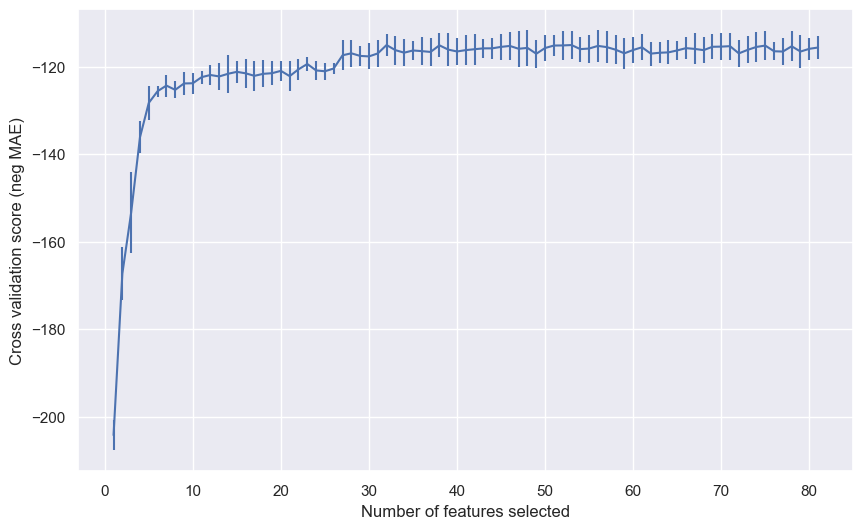

In [ ]:
# plot number of features vs. cross-validation scores
mean_test_scores = RFE_flights_ontime.named_steps['rfecv'].cv_results_['mean_test_score']
std_test_scores = RFE_flights_ontime.named_steps['rfecv'].cv_results_['std_test_score']
n_scores = len(mean_test_scores)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MAE)")
plt.errorbar(
    x=range(1, n_scores + 1),
    y=mean_test_scores,
    yerr=std_test_scores
)
plt.show()

FLIGHTS DELAYED - BEST FEATUREES

In [ ]:
# Get selected features
feature_names_in = RFE_flights_delay_pct.named_steps['columntransformer'].get_feature_names_out()
mask = RFE_flights_delay_pct.named_steps['rfecv'].support_
selected_features = feature_names_in[mask]
n_features = len(selected_features)

feature_ranking = RFE_flights_delay_pct.named_steps['rfecv'].ranking_

# Get names of the best features
best_features = feature_names_in[np.argsort(feature_ranking)[:n_features]]
print(f"\nBest {n_features} features for flights_delayed: {best_features}")


# Get names of the worst 10 features
worst_features = feature_names_in[np.argsort(feature_ranking)[-10:]]
print(f"\nWorst 10 features for flights_delayed: {worst_features}")


Best 28 features for flights_delayed: ['num__flights_cancel_lag_3' 'num__ordinal_date' 'num__day_of_month'
 'num__days_until_xmas' 'num__days_until_thanksgiving'
 'num__days_until_july_4th' 'num__days_until_labor_day'
 'num__days_until_memorial_day' 'num__wx_temperature_max'
 'num__wx_temperature_min' 'num__wx_apcp' 'num__wx_prate'
 'cat__season_summer' 'num__random' 'num__flights_cancel_lag_2'
 'cat__month_October' 'num__wx_lftx' 'num__wx_cape'
 'cat__day_of_week_Friday' 'num__wx_maxref' 'num__wx_gust'
 'num__flights_total_lag_1' 'num__wx_wind_speed' 'num__wx_wind_direction'
 'num__flights_total_lag_2' 'num__flights_total_lag_3' 'num__wx_vis'
 'num__flights_cancel_lag_1']

Worst 10 features for flights_delayed: ['cat__holiday_Juneteenth National Independence Day'
 'cat__day_before_easter_yes' 'cat__holiday_Memorial Day'
 'cat__holiday_Juneteenth National Independence Day (Observed)'
 'cat__holiday_Labor Day' 'cat__holiday_Veterans Day'
 'cat__holiday_Christmas Day' 'cat__holiday_Inde

FLIGHTS DELAYED - CROSS VALIDATION SCORE VS NUMBER OF FEATURES RETAINED

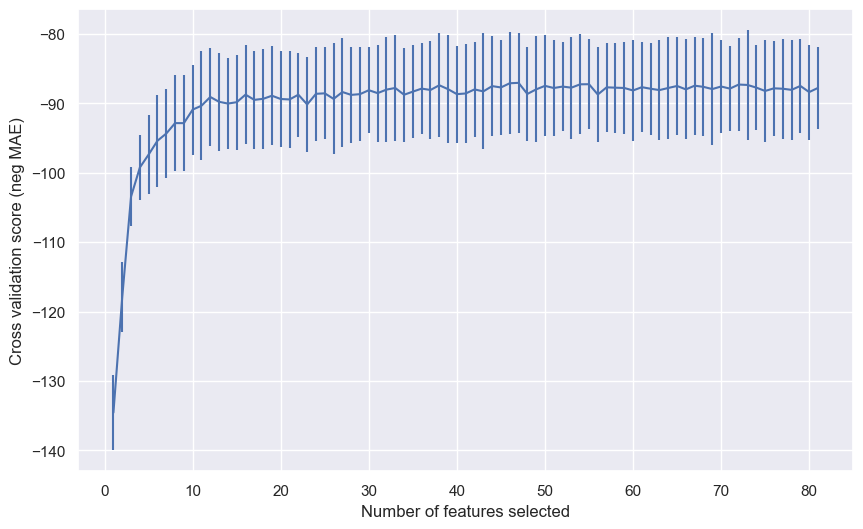

In [ ]:
# plot number of features vs. cross-validation scores
mean_test_scores = RFE_flights_delay.named_steps['rfecv'].cv_results_['mean_test_score']
std_test_scores = RFE_flights_delay.named_steps['rfecv'].cv_results_['std_test_score']
n_scores = len(mean_test_scores)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MAE)")
plt.errorbar(
    x=range(1, n_scores + 1),
    y=mean_test_scores,
    yerr=std_test_scores
)
plt.show()

### RFE QUESTIONS
1. Why does the random number feature score consistently in the top 10.
2. Why are cat_covid_no and cat_covid_yes frequently included in the top 10 features? These are complementary events, meaning no extra information should be obtained from including both compared to one.
3. Why are so many features retained (32 - 64), when a clear elbow and plateau consistently exists at around 8 features?
4. WHY does RFE using estiamtor=LinearRegression produce such a bizzare cross validation score x num features plot?